<a href="https://colab.research.google.com/github/akhandait/advanced-machine-learning-with-neural-networks-homeworks/blob/main/homeworks/hw1_problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 1 | Problem 4

In [ ]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

## Implementing a Convolutional Neural Network for Classification

Define a convolutional neural network with a dense top ...

In [22]:
import torch
import deeplay as dl

In [25]:
cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1, hidden_channels=[16, 32], out_channels=64,
        pool=torch.nn.MaxPool2d(kernel_size=2), out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(torch.nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64, hidden_features=[32, 32], out_features=1,
        out_activation=torch.nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
  )
  (1): Layer[MaxPool2d](kernel_size=2)
  (2): Layer[Flatten]()
  (3): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=2304, out_features=32, bias=True)
        (activa

... and compile it for a regression task.

In [26]:
from torchmetrics import MeanAbsoluteError as MAE

cnn_regressor_template = dl.Regressor(
    model=cnn, loss=torch.nn.MSELoss(), optimizer=dl.Adam(), metrics=[MAE()],
)
cnn_ann_regressor = cnn_regressor_template.create()

print(cnn_ann_regressor)

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64,

## Simulating the Training Data

Define the particle ...

In [27]:
image_size = 51

In [28]:
import deeptrack as dt

particle = dt.scatterers.MieSphere(
    position=lambda: np.random.uniform(image_size / 2 - 5,
                                       image_size / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, 1),
    radius=lambda: np.random.uniform(400, 800) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


... specify the optical device to image the particle ...

In [29]:
brightfield_microscope = dt.optics.Brightfield(
    wavelength=630e-9, NA=0.8, resolution=1e-6, magnification=15,
    refractive_index_medium=1.33, output_region=(0, 0, image_size, image_size),
)

... combine them ...

In [30]:
imaged_particle = brightfield_microscope(particle)

... and plot them.

In [31]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def plot_simulated_particles(image_pipeline):
    """Plot simulated particles."""
    fig, axs = plt.subplots(1, 6, figsize=(25, 8))
    for i, ax in enumerate(axs.flatten()):
        image = image_pipeline.update().resolve()
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

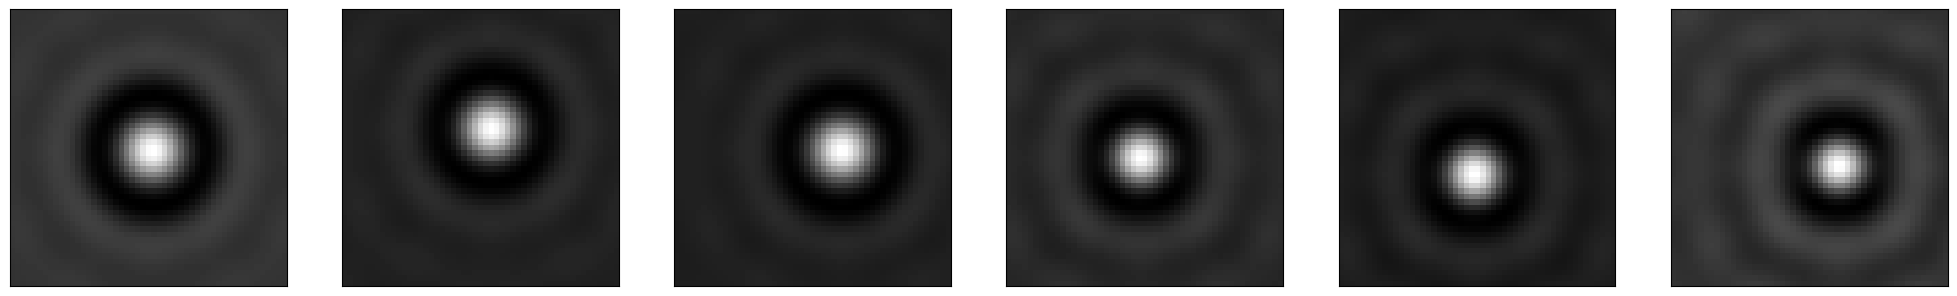

In [33]:
plot_simulated_particles(imaged_particle)

### Creating Images of Particles with Noise

Adding a Poisson noise source to the simulation pipeline ...

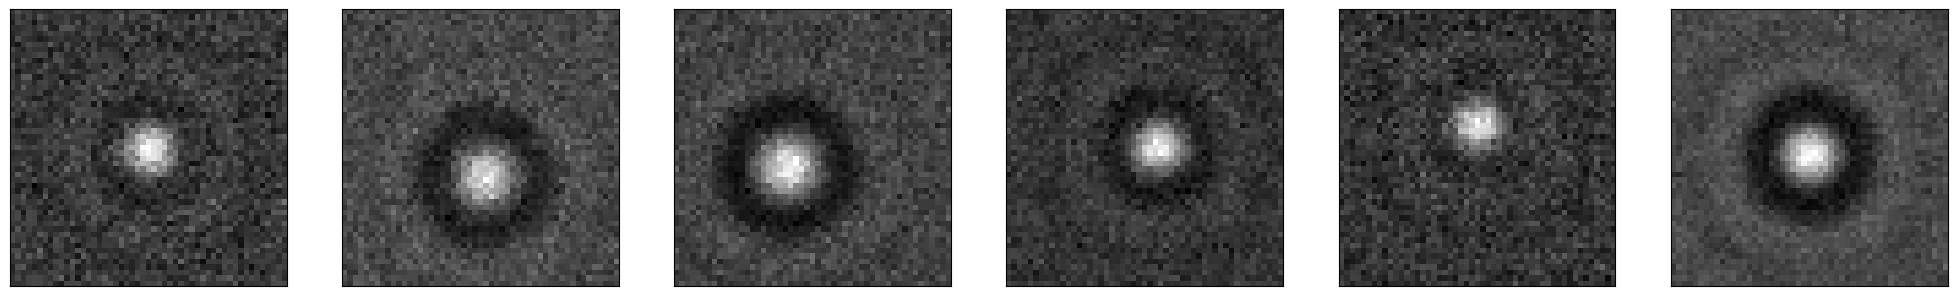

In [34]:
noise = dt.Poisson(
    min_snr=5, max_snr=20, background=1,
    snr=lambda min_snr, max_snr: np.random.uniform(min_snr, max_snr),
)
noisy_imaged_particle = imaged_particle >> noise

plot_simulated_particles(noisy_imaged_particle)

... and create a pipeline that generates noisy particle images and normalize the pixel values.

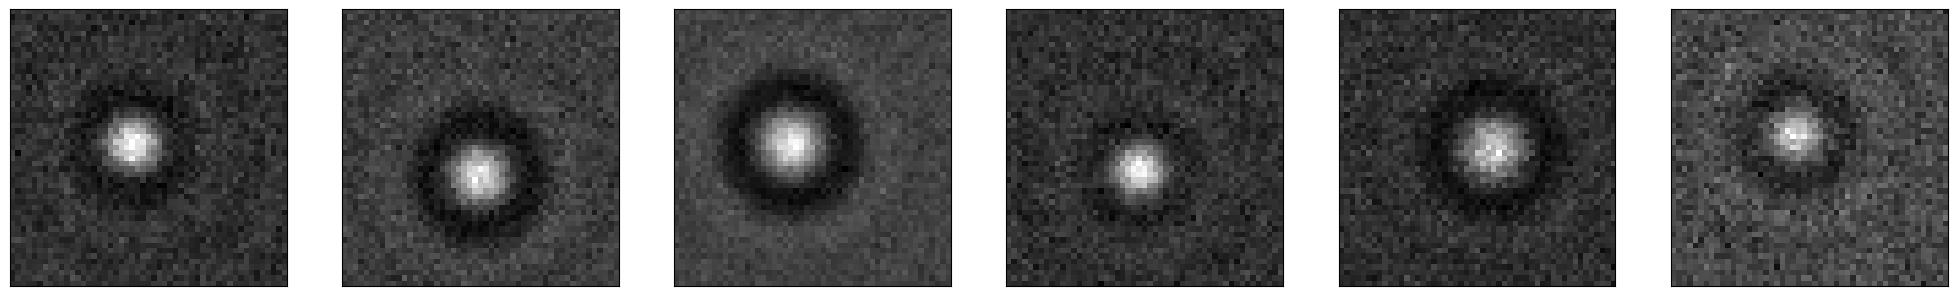

In [35]:
normalization = dt.NormalizeMinMax(lambda: np.random.uniform(0.0, 0.2),
                                   lambda: np.random.uniform(0.8, 1.0))
image_pipeline = noisy_imaged_particle >> normalization

plot_simulated_particles(image_pipeline)

### Getting the Positions from the Simulated Images

Define a pipeline to obtain both the particle image and its centroid position ...

In [36]:
pipeline = image_pipeline & particle.radius

### Preprocessing the Simulated Data

Create a database to work with the simulated particle images ...

In [37]:
class SimulatedDataset(torch.utils.data.Dataset):
    """Dataset with simulated particles."""

    def __init__(self, pipeline, data_size):
        """Initialize simulated dataset."""
        images, radii = [], []
        for _ in range(data_size):
            image, radius = pipeline.update().resolve()
            images.append(image), radii.append(radius)
        self.images, self.radii = np.array(images), np.array(radii)

    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]

    def __getitem__(self, idx):
        """Get next simulated image and position."""
        im = torch.tensor(self.images[idx]).float().permute(2, 0, 1)
        rad = torch.tensor(self.radii[idx] * 1e7).float().unsqueeze(-1)
        return [im, rad]

... and create the training and test data loaders.

In [38]:
train_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=25000), batch_size=64,
)
test_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=500), batch_size=32,
)

## Training the Neural Network with Simulated Data

In [39]:
cnn_sim_regressor = cnn_regressor_template.create()
cnn_sim_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_sim_trainer.fit(cnn_sim_regressor, train_sim_dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 98.1 K | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
98.1 K    Trainable params
0         Non-trainable params
98.1 K    Total params
0.393     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

### Testing the Trained Neural Network

In [41]:
test_sim_results = cnn_sim_trainer.test(cnn_sim_regressor, test_sim_dataloader)
MAE_sim = test_sim_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_sim:.3f} pixels")

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMeanAbsoluteError_epoch │     0.1962222456932068      │
│       test_loss_epoch       │     0.06059616059064865     │
└─────────────────────────────┴─────────────────────────────┘

Mean pixel error (MAE): 10.007 pixels


### Plotting the Predictions Versus the Ground Truth

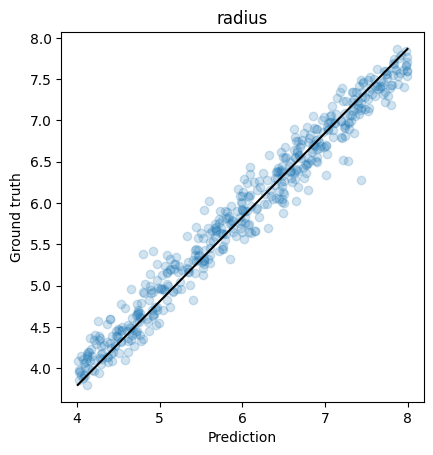

In [42]:
preds, gts = [], []
for image, radius in iter(test_sim_dataloader):
    preds.append(cnn_sim_regressor(image))
    gts.append(radius)

pred = torch.cat(preds, dim=0).detach().numpy()
gt = torch.cat(gts, dim=0).numpy()

fig, ax = plt.subplots()
ax.scatter(gt, pred, alpha=0.2)
ax.plot([np.min(gt), np.max(gt)], [np.min(pred), np.max(pred)], c="k")
ax.set_title(f"radius")
ax.set_xlabel("Prediction")
ax.set_ylabel("Ground truth")
ax.set_aspect("equal")
ax.label_outer()

plt.show()

In [43]:
import numpy as np

In [44]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, image_path, label_path=None, transform=None):
        self.images = np.load(image_path)
        self.labels = np.load(label_path) if label_path else None
        self.transform = transform

        # Optional: convert images to float32 if needed
        self.images = self.images.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Convert image to torch tensor
        image = torch.from_numpy(image)

        # Apply transform if needed (e.g., normalization)
        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [15]:
temp = np.load("annotated_images.npy", allow_pickle=True)

In [17]:
temp[0].shape

(51, 51)

In [16]:
temp.shape

(100, 51, 51)

In [18]:
experimental_dataset = CustomImageDataset("annotated_images.npy")

In [23]:
experimental_dataloader = dl.DataLoader(
    experimental_dataset, batch_size=32,
)

In [70]:
temp_in = torch.Tensor(temp).unsqueeze(1)

In [71]:
temp_in.shape

torch.Size([100, 1, 51, 51])

In [78]:
pred_exp = cnn_ann_regressor.model(temp_in)

### Visualizing the Activations of the Convolutional Layers

In [48]:
exp_sample = torch.Tensor(temp[0]).unsqueeze(0)

sim_dataset = SimulatedDataset(pipeline=pipeline, data_size=100)
sim_sample = sim_dataset[0][0]

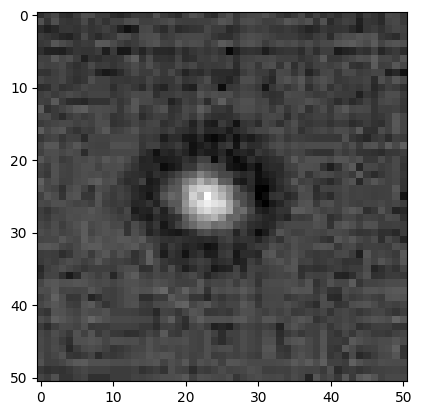

In [90]:
from matplotlib import pyplot as plt
plt.imshow(temp[0], interpolation='nearest', cmap='gray')
plt.show()

In [51]:
from torch.nn.functional import relu

from numpy import array
from skimage.exposure import rescale_intensity
from skimage.transform import resize

In [52]:
def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)

    plt.show()

#### Simulated image

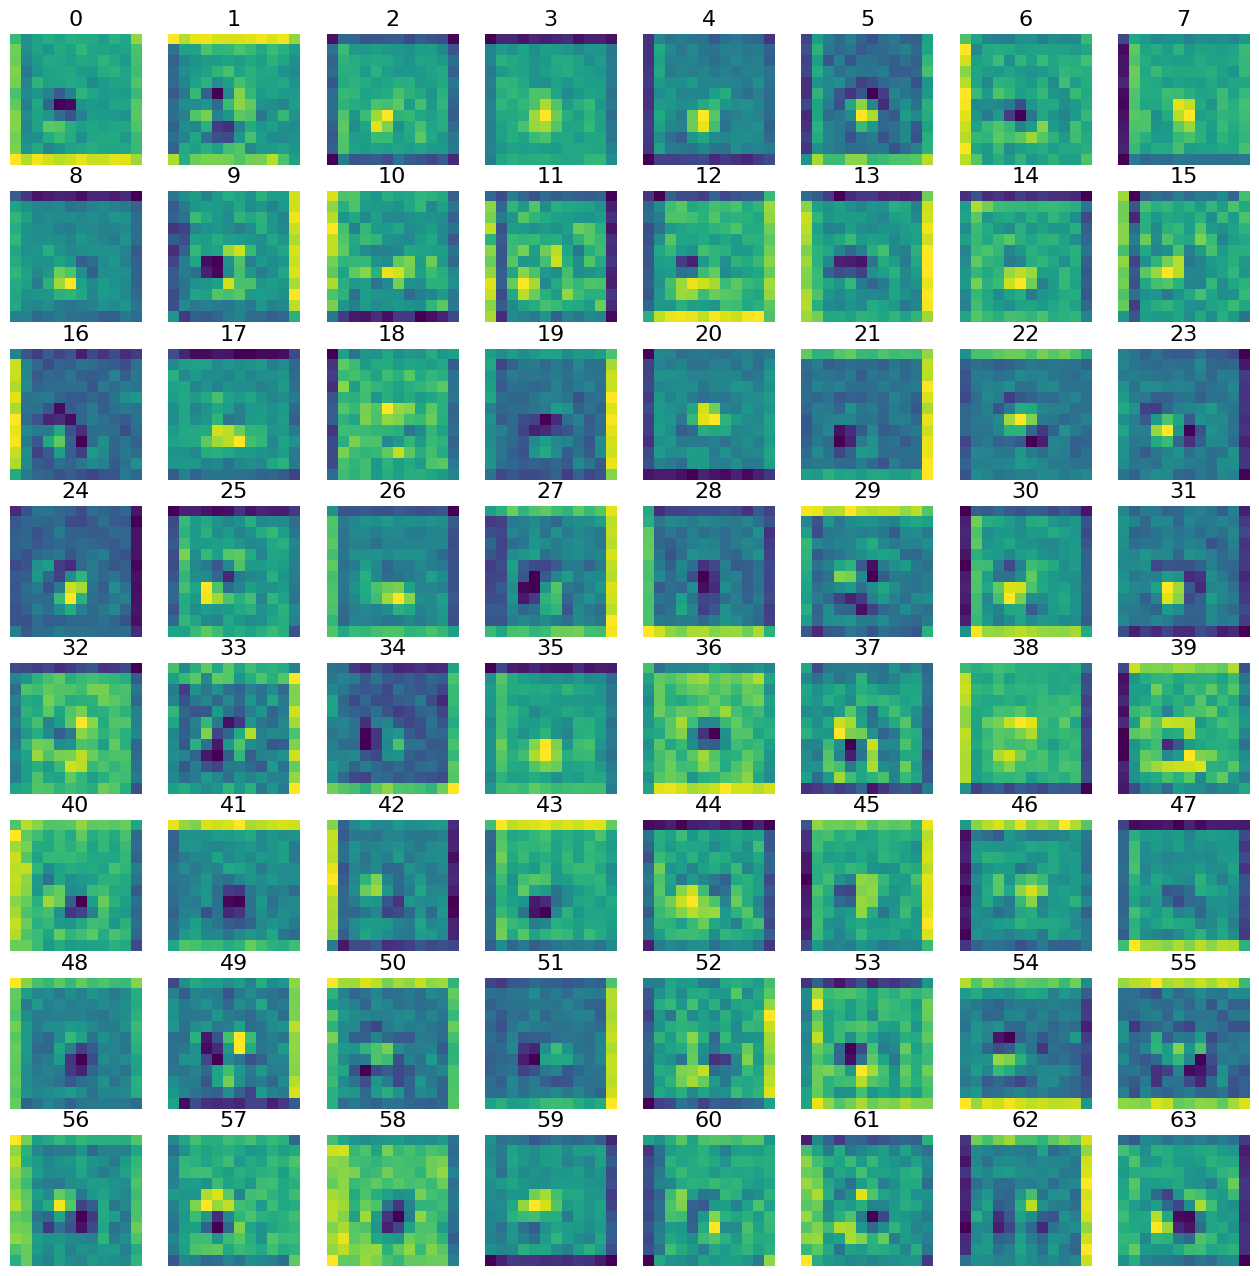

In [54]:
def hook_func_no_plot(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()

def hook_func_plot(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_ann_regressor.model[0].blocks:
    layer = block.layer
    if block == cnn_ann_regressor.model[0].blocks[2]:
        handle_hook = layer.register_forward_hook(hook_func_plot)
    else:
        handle_hook = layer.register_forward_hook(hook_func_no_plot)

    # handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_ann_regressor.model(sim_sample.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

#### Experimental image

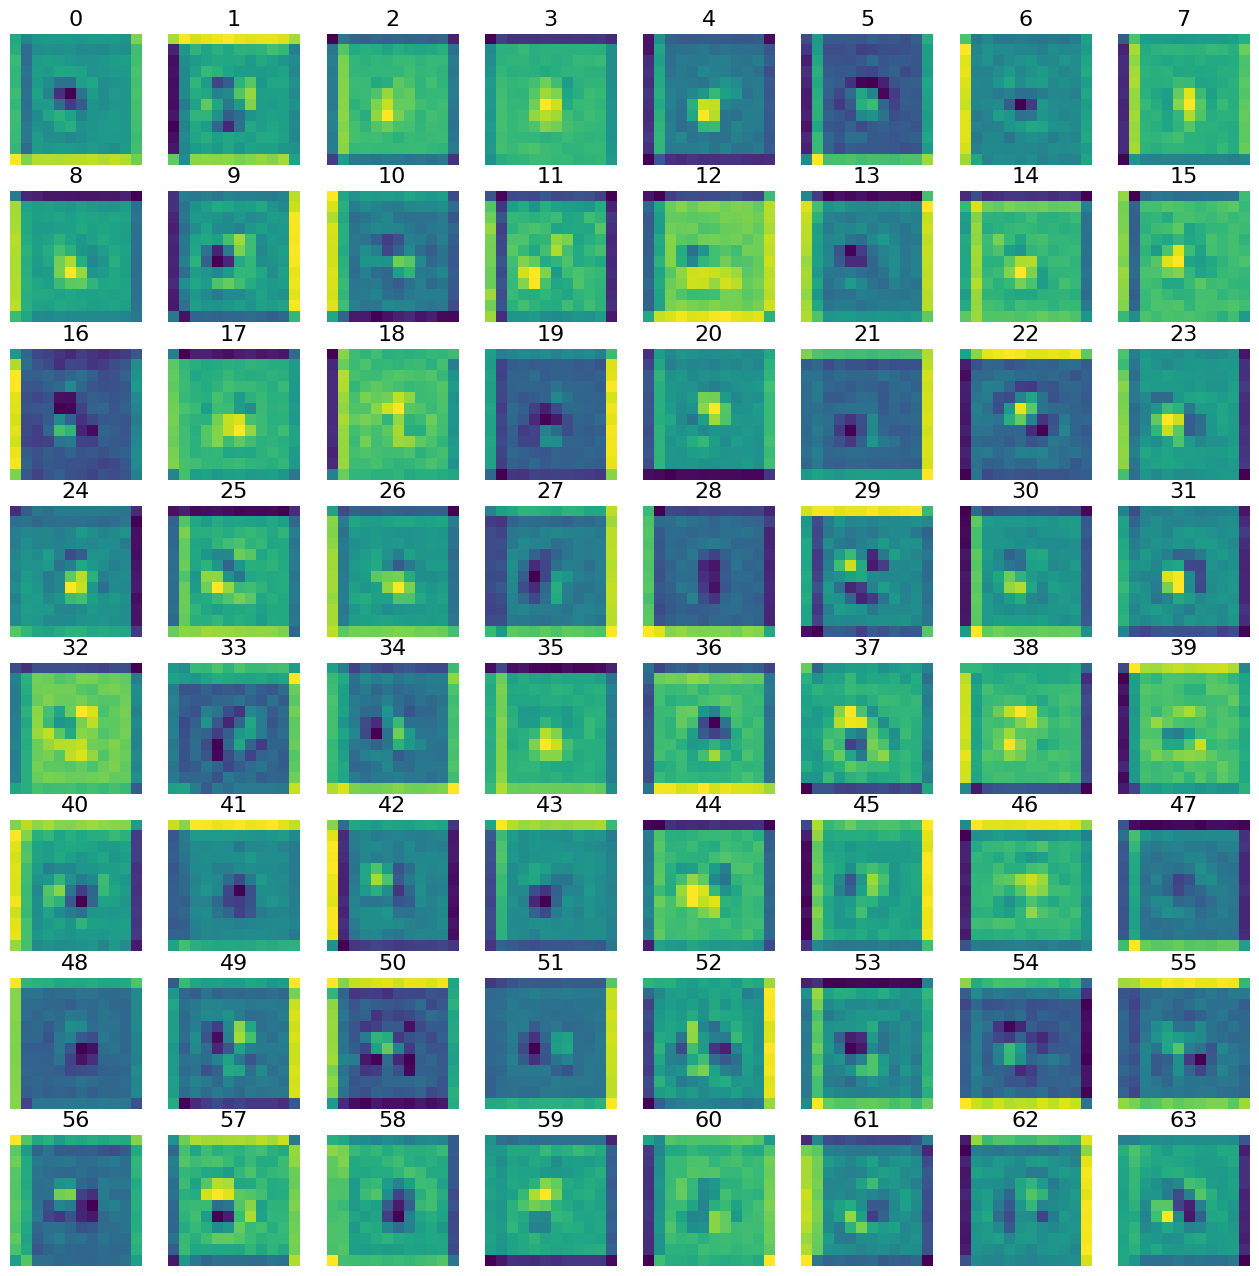

In [55]:
for block in cnn_ann_regressor.model[0].blocks:
    layer = block.layer
    if block == cnn_ann_regressor.model[0].blocks[2]:
        handle_hook = layer.register_forward_hook(hook_func_plot)
    else:
        handle_hook = layer.register_forward_hook(hook_func_no_plot)

    # handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_ann_regressor.model(exp_sample.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

We can see some differences in intensity of the activations in the simulated vs. experimental data. There are multiple possible reasons for this:\
\
1) The experimental data was collected and prepared for the task of particle localization. This is different from the task for which we prepared the simulated data(particle size prediction). The range of particle radii is much mkore in our data than in the particle localization data.\
\
2) Another factor could be that even after adding noise to the simulated data as we have done, it still slightly differes in statistics from the experimental data.\
\
So, the differences in activations most likely arise from the model not generalizing well to the experimental data because the training data(simulated data) and the testing data(experimental data) are from slightly different disitributions.